In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad

from torch.utils.data import Dataset, DataLoader

# Define Utility Functions and Model

In [2]:
def soft_threshold(x, lambd):
    return torch.sign(x) * torch.max(torch.abs(x) - lambd, torch.zeros_like(x))

def hard_threshold(x, lambd):
    return x * (torch.abs(x) > lambd).float()

In [3]:
# MLCSC6 returns the reconstructed image from the latent space (n_batch, 1024, 2, 2)
class MLCSC6(nn.Module):
    def __init__(self, n_layers = 6):
        super(MLCSC6, self).__init__()
        
        D1 = nn.ConvTranspose2d(128, 3, kernel_size=6, stride=2, padding=0)
        D2 = nn.ConvTranspose2d(128, 128, kernel_size=3, stride=1, padding=0)
        D3 = nn.ConvTranspose2d(128, 128, kernel_size=3, stride=1, padding=0)
        D4 = nn.ConvTranspose2d(128, 128, kernel_size=3, stride=1, padding=0)
        D5 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=0)
        D6 = nn.ConvTranspose2d(256, 256, kernel_size=5, stride=1, padding=0)
        
        #self.layers = [D6, D5, D4, D3, D2, D1]
        self.layers = [D6, D5, D4, D3, D2, D1]
        self.n_layers = n_layers
        self.layers = nn.ModuleList(self.layers[6-n_layers:])
        self.strides = [1, 1, 1, 1, 1, 2][6-n_layers:]
        self.ksizes = [5, 3, 3, 3, 3, 6][6-n_layers:]
    
    def F(self, x, lambd = 0.1):
        return torch.div(torch.square(x).flatten(1).sum(1), 2) + lambd * torch.abs(x).flatten(1).sum(1)
    
    def initialize(self, x):
        
        for i in range(self.n_layers-1, -1, -1):
            x = F.conv2d(x, self.layers[i].weight, stride=self.strides[i], padding=0)
            #x = self.layers[i](x)
            #print(x.shape)
        #pass
        return x
    
    def FISTA(self, x, y, lambd = 0.03, n_iter = 100):
        batch_size = x.size(0)
        Dx = self.forward(x)
        
        gradient = Dx-y
        for i in range(self.n_layers, 0, -1):
            gradient = F.conv2d(gradient, self.layers[i-1].weight, stride=self.strides[i-1], padding=0)
        tk, tk_next = torch.tensor(1., device = x.device), torch.tensor(1., device = x.device)
        loss_list = []
        for _ in range(n_iter):
            z = x.clone()
            const = self.F(z, lambd).reshape(-1, 1, 1, 1)
            
            L = torch.ones((batch_size, 1, 1, 1), device = x.device)
            stop_line_search = torch.zeros((batch_size), device=x.device).bool()
            while torch.sum(stop_line_search) < batch_size:
                # line search
                # print(z.shape, gradient.shape, L.shape)
                prox_z = soft_threshold(z - torch.div(gradient, L), torch.div(lambd, L))
                
                # check descent condition
                temp1 = self.F(prox_z, lambd).reshape(-1, 1, 1, 1)
                temp2 = const + torch.mul(gradient, prox_z - z).flatten(1).sum(1).reshape(-1, 1, 1, 1) + \
                                torch.div(L, 2) * torch.square(prox_z - z).flatten(1).sum(1).reshape(-1, 1, 1, 1)
                stop_line_search = temp1 <= temp2
                L = torch.where(stop_line_search, L, 2 * L)
            
            tk_next = (1 + torch.sqrt(1 + 4 * tk**2)) / 2
            x = prox_z + torch.div(tk - 1, tk_next) * (prox_z - z)
            tk = tk_next
            loss_list.append(torch.mean(self.F(x, lambd)).item())
        
        return x, loss_list
    
    def IHT(self, lambds):
        # lambd2, lambd3 = 0.005, 0.01#0.01, 0.005, 0.01
        # self.layer1.weight = hard_threshold(self.layer1.weight, lambd1)
        # self.layer2.weight = nn.Parameter(hard_threshold(self.layer2.weight, lambd2))
        # self.layer3.weight = nn.Parameter(hard_threshold(self.layer3.weight, lambd3))
        for i in range(1, self.n_layers):
            self.layers[i].weight = nn.Parameter(hard_threshold(self.layers[i].weight, lambds[i-1]))
            #print(torch.sum(self.layers[i].weight.flatten()==0) / torch.numel(self.layers[i].weight))
    
    def forward(self, x):
        for i in range(self.n_layers):
            x = self.layers[i](x)
        
        return x
    


In [4]:
data = np.load('zca_images.npy')
print(data.shape)

(50000, 3, 32, 32)


# Visualization

torch.Size([1, 4, 3, 16, 16])


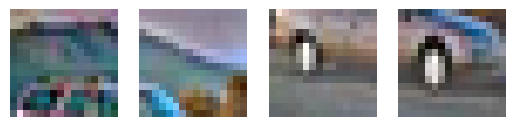

(-0.5, 31.5, 31.5, -0.5)

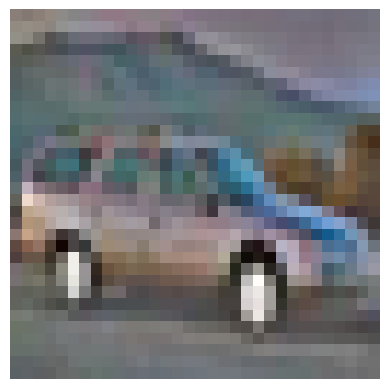

In [5]:
def make_patches(img, patch_size):
    # outupt shape: (batch, n_patches, patch_size^2, 1)
    try:
        assert img.shape[2] % patch_size == 0
        patches = img.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
        patches = patches.contiguous().view(patches.size(0), 3, -1, patch_size, patch_size).permute(0, 2, 1, 3, 4)
        return patches
    except:
        raise ValueError('Image size must be divisible by patch size')

idx = 4
x = torch.from_numpy(data[idx:idx+1])
patches = make_patches(x, 16)
print(patches.shape)
# patches = patches.reshape(4, 3, 16, 16)

fig, ax = plt.subplots(1, 4)
for i in range(4):
    patch = patches[0, i, :,:, :].cpu().permute(1,2,0).numpy()
    patch = (patch - patch.min()) / (patch.max() - patch.min())
    ax[i].imshow(patch)
    ax[i].axis('off')
    
plt.show()
x = x.squeeze().cpu().permute(1,2,0).numpy()
x = (x - x.min()) / (x.max() - x.min())
plt.imshow(x)
plt.axis('off')

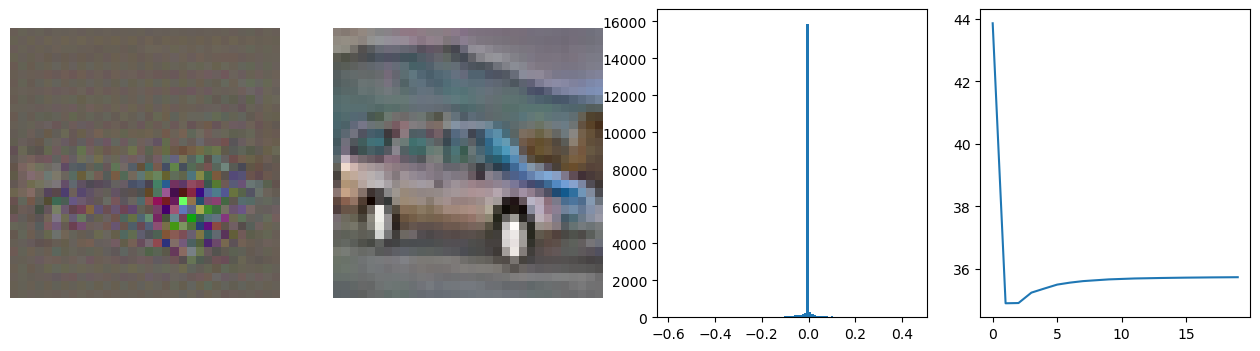

tensor(0.7188)
tensor(0.4528) tensor(-0.5969)
0.07195591926574707


In [19]:
model_dec = MLCSC6(2)
model_dec.cuda()
#code = torch.randn(1, 256, 10, 10).cuda()

#print(recon.shape)
idx = 2
x = torch.from_numpy(data[idx:idx+32]).cuda()

code = model_dec.initialize(x)
#code = torch.randn_like(code).cuda()

sparse_code, loss_list = model_dec.FISTA(code, x, lambd=0.1, n_iter=20)
recon = model_dec(sparse_code)

fig, ax = plt.subplots(1, 4, figsize=(16, 4))

idx = 2

reconstruction = recon[idx].detach().cpu().permute(1, 2, 0).numpy()
reconstruction = (reconstruction - np.min(reconstruction)) / (np.max(reconstruction) - np.min(reconstruction))
label = x[idx].detach().cpu().permute(1, 2, 0).numpy()
label = (label - np.min(label)) / (np.max(label) - np.min(label))
ax[0].imshow(reconstruction)
ax[1].imshow(label)
_ = ax[2].hist(sparse_code[0].detach().cpu().flatten(), bins=100)
for i in range(2):
    # remove axis
    ax[i].axis('off')
ax[3].plot(loss_list)
plt.show()

print(torch.sum(sparse_code[0].detach().cpu().flatten()==0) / torch.numel(sparse_code[0].detach().cpu().flatten()))
print(sparse_code[0].detach().cpu().flatten().max(), sparse_code[0].detach().cpu().flatten().min())
print(torch.mean(torch.square(recon - x)).item())


In [22]:
idx = np.random.randint(0, 50000, 32)
batch_data = data[idx]
x = torch.FloatTensor(batch_data).cuda()
for i in range(1, 7):
    model_dec = MLCSC6(i)
    model_dec.cuda()
    
    code = model_dec.initialize(x)
    #code = torch.randn_like(code).cuda()

    sparse_code, loss_list = model_dec.FISTA(code, x, lambd=0.03, n_iter=20)
    recon = model_dec(sparse_code)
    
    torch.save(recon.cpu(), 'cifar-10/recon_{}.pt'.format(i))
    
# batch_data

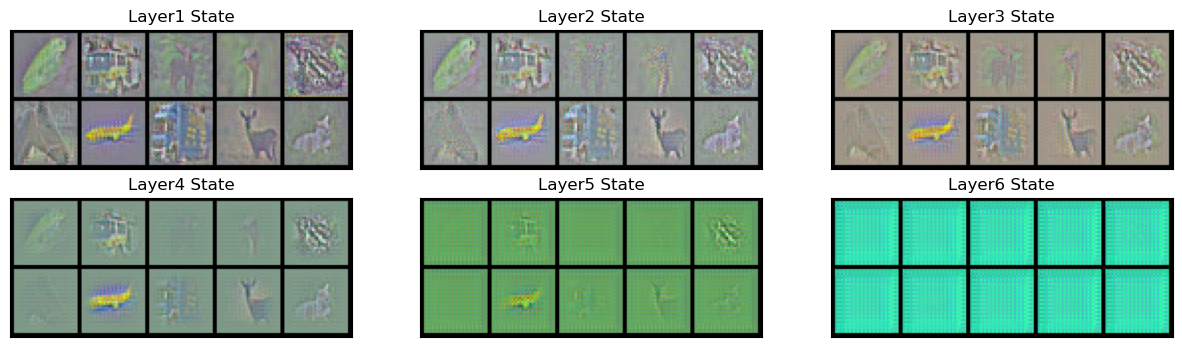

In [17]:
from torchvision.utils import make_grid

recon11 = torch.load('cifar-10/recon_1.pt')[-10:]
recon11 = make_grid(recon11, nrow=5, normalize=True).cpu().numpy()

recon12 = torch.load('cifar-10/recon_2.pt')[-10:]
recon12 = make_grid(recon12, nrow=5, normalize=True).cpu().numpy()

recon21 = torch.load('cifar-10/recon_3.pt')[-10:]
recon21 = make_grid(recon21, nrow=5, normalize=True).cpu().numpy()

recon22 = torch.load('cifar-10/recon_4.pt')[-10:]
recon22 = make_grid(recon22, nrow=5, normalize=True).cpu().numpy()

recon31 = torch.load('cifar-10/recon_5.pt')[-10:]
recon31 = make_grid(recon31, nrow=5, normalize=True).cpu().numpy()

recon32 = torch.load('cifar-10/recon_6.pt')[-10:]
recon32 = make_grid(recon32, nrow=5, normalize=True).cpu().numpy()


plt.figure(figsize=(15,4))
plt.tight_layout()
plt.subplot(2,3,1)
plt.imshow(np.transpose(recon11,[1,2,0]))
plt.title('Layer1 State')
plt.xticks([])
plt.yticks([])
plt.subplot(2,3,2)
plt.imshow(np.transpose(recon12,[1,2,0]))
plt.title('Layer2 State')
plt.xticks([])
plt.yticks([])
plt.subplot(2,3,3)
plt.imshow(np.transpose(recon21,[1,2,0]))
plt.title('Layer3 State')
plt.xticks([])
plt.yticks([])
plt.subplot(2,3,4)
plt.imshow(np.transpose(recon22,[1,2,0]))
plt.title('Layer4 State')
plt.xticks([])
plt.yticks([])
plt.subplot(2,3,5)
plt.imshow(np.transpose(recon31,[1,2,0]))
plt.title('Layer5 State')
plt.xticks([])
plt.yticks([])
plt.subplot(2,3,6)
plt.imshow(np.transpose(recon32,[1,2,0]))
plt.title('Layer6 State')
plt.xticks([])
plt.yticks([])
#plt.show()

plt.savefig('cifar-10/ML-CSC.pdf',bbox_inches='tight')

In [7]:
test = model_dec.initialize(x)
print(test.shape)

torch.Size([32, 256, 10, 10])


In [21]:
class dataset(Dataset):
    def __init__(self):
        self.data = np.load('zca_images.npy')
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]


In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLCSC6(6)
model = model.to(device)

cifar10 = dataset()
cifar_loader = DataLoader(cifar10, batch_size=32, shuffle=True, num_workers=8)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.001)

for epoch in range(1,51):
    loss_list = []
    for batch_id, data in enumerate(cifar_loader):
        data = data.cuda()
        # code = torch.randn(data.size(0), 1024, 10, 10).cuda()
        
        with torch.no_grad():
            code = model.initialize(data.clone())
            x, _ = model.FISTA(code, data.clone(), lambd=0.03, n_iter=10)
        
        optimizer.zero_grad()
        x = x.clone().requires_grad_(True)
        output = model(x)
        loss = F.mse_loss(output, data)
        
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        # iterative hard thresholding step
        # model.IHT()
        model.IHT([0.001, 0.005, 0.01, 0.025, 0.05])
        #model.IHT([0.01, 0.05])
        
        if batch_id % 200 == 0:
            l1_ratio = [(torch.sum(model.layers[i].weight.flatten()==0) / torch.numel(model.layers[i].weight)).item() for i in range(1, model.n_layers)]
            print("loss", "{:.4f}".format(loss.item()), "sparsity:", ["{0:0.2f}".format(i) for i in l1_ratio])
            # print([np.abs(model.layers[i].weight.cpu().detach().numpy().flatten()).max() for i in range(model.n_layers)])
    print(f'epoch {epoch}, batch {batch_id}, loss {np.mean(loss_list)}\n')
    
    
    # if epoch % 10 == 0:
torch.save(model.state_dict(), f'model_cifar.pt')

loss 0.0701 sparsity: ['0.03', '0.17', '0.34', '0.85', '0.52']
loss 0.0618 sparsity: ['0.03', '0.17', '0.34', '0.85', '0.52']
loss 0.0735 sparsity: ['0.03', '0.17', '0.34', '0.85', '0.52']
loss 0.0711 sparsity: ['0.03', '0.17', '0.34', '0.85', '0.52']
loss 0.0814 sparsity: ['0.03', '0.17', '0.34', '0.85', '0.52']
loss 0.0547 sparsity: ['0.03', '0.17', '0.34', '0.85', '0.52']
loss 0.0670 sparsity: ['0.03', '0.17', '0.34', '0.85', '0.52']
loss 0.0761 sparsity: ['0.03', '0.17', '0.34', '0.85', '0.52']
epoch 1, batch 1562, loss 0.06819799374157393

loss 0.0595 sparsity: ['0.03', '0.17', '0.34', '0.85', '0.52']
loss 0.0712 sparsity: ['0.03', '0.17', '0.34', '0.85', '0.52']
loss 0.0710 sparsity: ['0.03', '0.17', '0.34', '0.85', '0.52']
loss 0.0746 sparsity: ['0.03', '0.17', '0.34', '0.85', '0.52']
loss 0.0638 sparsity: ['0.03', '0.17', '0.34', '0.85', '0.52']
loss 0.0677 sparsity: ['0.03', '0.17', '0.34', '0.85', '0.52']
loss 0.0631 sparsity: ['0.03', '0.17', '0.34', '0.85', '0.52']
loss 0.0

KeyboardInterrupt: 

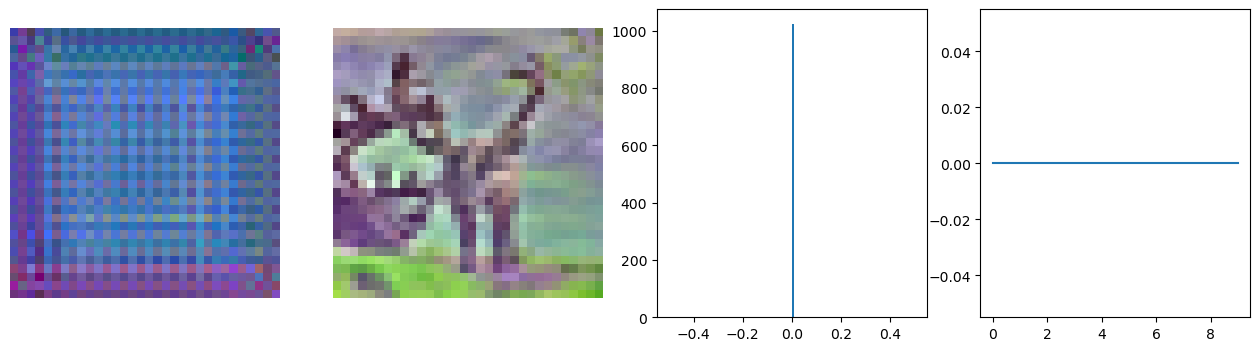

tensor(1.)
tensor(0.) tensor(0.)
0.061741024255752563


In [24]:

#print(recon.shape)
idx = 2
#x = torch.from_numpy(data[idx:idx+32]).cuda()
x = data

code = model.initialize(x)
#code = torch.randn_like(code).cuda()

sparse_code, loss_list = model.FISTA(code, x, lambd=0.03, n_iter=10)
recon = model(sparse_code)

fig, ax = plt.subplots(1, 4, figsize=(16, 4))

idx = 8

reconstruction = recon[idx].detach().cpu().permute(1, 2, 0).numpy()
reconstruction = (reconstruction - np.min(reconstruction)) / (np.max(reconstruction) - np.min(reconstruction))
label = x[idx].detach().cpu().permute(1, 2, 0).numpy()
label = (label - np.min(label)) / (np.max(label) - np.min(label))
ax[0].imshow(reconstruction)
ax[1].imshow(label)
_ = ax[2].hist(sparse_code[0].detach().cpu().flatten(), bins=100)
for i in range(2):
    # remove axis
    ax[i].axis('off')
ax[3].plot(loss_list)
plt.show()

# idx = 10

print(torch.sum(sparse_code[idx].detach().cpu().flatten()==0) / torch.numel(sparse_code[idx].detach().cpu().flatten()))
print(sparse_code[idx].detach().cpu().flatten().max(), sparse_code[idx].detach().cpu().flatten().min())
print(torch.mean(torch.square(recon - x)).item())


0.18270263671875


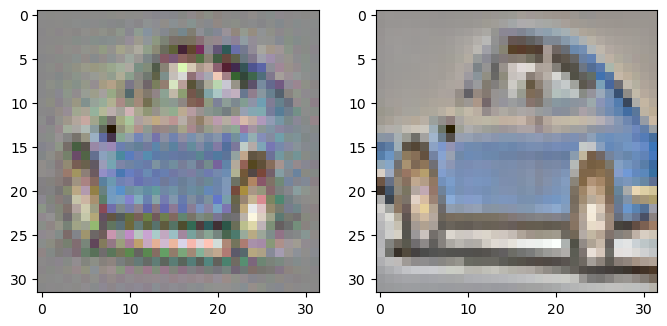

In [29]:
output.shape
idx = -6
#plt.imshow(output[idx].cpu().detach().numpy().reshape(28, 28), cmap='gray')
#plt.show()
#plt.imshow(data[idx].cpu().detach().numpy().reshape(28, 28), cmap='gray')

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
out = output[idx].cpu().permute(1,2,0).detach().numpy()
out = (out - out.min()) / (out.max() - out.min())
lab = data[idx].cpu().permute(1,2,0).detach().numpy()
lab = (lab - lab.min()) / (lab.max() - lab.min())
ax[0].imshow(out, cmap='gray')
ax[1].imshow(lab, cmap='gray')

#fig, ax = plt.subplots(1, 3, figsize=(9, 3))
#ax[0].hist(model.layer2.weight.cpu().detach().numpy().flatten(), bins=200)
#ax[1].hist(model.layer3.weight.cpu().detach().numpy().flatten(), bins=200)
#ax[2].hist(x.cpu().detach().numpy().flatten(), bins=200)
#plt.show()

print(np.sum(x.cpu().detach().numpy().flatten()==0) / x.cpu().detach().numpy().size)